<a href="https://colab.research.google.com/github/nikorose87/DJS-GA/blob/master/PCA_n_kPCA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification and Regression plus feature extraction using Gait data

## Prof. Nikolay Prieto 
*Universidad de San Buenaventura - Sede Bogotá*

We are going to apply Artificial Intelligence techniques to classify either the speed of the subject and the age group according to the data given from Horst's article [doi](https://data.mendeley.com/datasets/svx74xcrjr/3).



Let us explain the procedure:



In [ ]:
!wget https://www.dropbox.com/s/bqodz4qn7zhi3cz/Horst_mean.csv
!wget https://www.dropbox.com/s/2bfc8vne4rx7o9d/Gait_subject_info.csv
!wget https://www.dropbox.com/s/8g3kimgzy7j4o5x/Horst_Nature_paper.csv

--2020-10-21 00:16:57--  https://www.dropbox.com/s/bqodz4qn7zhi3cz/Horst_mean.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bqodz4qn7zhi3cz/Horst_mean.csv [following]
--2020-10-21 00:16:57--  https://www.dropbox.com/s/raw/bqodz4qn7zhi3cz/Horst_mean.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc168fdb01890a244a44107aa0ae.dl.dropboxusercontent.com/cd/0/inline/BBpyrgqj7xlxwa7fyTdukNiTZOus4150bBnHWXPH4RHOzvdJ2f2-NJ1h-P0X154mF-sO7-RbS2VEBlW0se7GdbL3C7tglMg_qip6TX196TfurADyAInkDGUfL9c-rqBu0qk/file# [following]
--2020-10-21 00:16:58--  https://uc168fdb01890a244a44107aa0ae.dl.dropboxusercontent.com/cd/0/inline/BBpyrgqj7xlxwa7fyTdukNiTZOus4150bBnHWXPH4RHOzvdJ2f2-NJ1h-P0X154mF-sO7-RbS2VEBlW0se7GdbL3C7tglMg_qip6TX196Tfu

In [ ]:
#Checking if the file is already there
import sys
import os
#print(sys.path)
!pwd
!ls

/content
 Gait_subject_info.csv	   Horst_mean.csv.1	  Horst_Nature_paper.csv
 Gait_subject_info.csv.1   Horst_mean.csv.2	  Horst_Nature_paper.csv.1
 Gait_subject_info.csv.2   Horst_mean.csv.3	  Horst_Nature_paper.csv.2
 Gait_subject_info.csv.3   Horst_mean.csv.4	  Horst_Nature_paper.csv.3
 Gait_subject_info.csv.4   Horst_mean.csv.5	 'Horst_Nature_paper.csv?dl=0'
 Horst_mean.csv		  'Horst_mean.csv?dl=1'   sample_data


# Some concepts about Human Gait

## How the planes in human motion are named

![human planes](https://drive.google.com/uc?id=1icMDhWCw_1s4FKYPgSEJYIUX7_Wwo3x1)

## Terminology in movements
![movements in gait](https://drive.google.com/uc?id=1hTtXIwNR7VXbimmYdlbwW4t1eQPFSnXn)

## Terminology only for ankle foot
![foot movements](https://drive.google.com/uc?id=1_kTatzluVRXAC2D1XhaP7X48M02MkUkZ)

## How the data was processed 

![Opensim](https://raw.githubusercontent.com/opensim-org/opensim-core/master/doc/images/opensim_running.gif)

With Opensim we have obtained all the kinematic and kinetic data for each trial with the following procedure:

![Kinematics](https://simtk-confluence.stanford.edu:8443/download/attachments/29164184/worddav18beee95e9328969b6f5ee05a6c736f0.png?version=1&modificationDate=1530846003979&api=v2)





In [ ]:
import warnings
import numpy as np
import pandas as pd
from bokeh.layouts import row, column
from bokeh.palettes import Spectral6, Set3
from bokeh.plotting import figure, show, gridplot
from bokeh.models import ColumnDataSource
from bokeh.models.glyphs import Text
from bokeh.io import reset_output, output_notebook
from scipy.integrate import simps
import scipy.optimize as optimization
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pathlib import PurePath
import os
warnings.filterwarnings('ignore')
output_notebook()
##Cleaning and selecting the data
reset_output()

Horst_mean = pd.read_csv('Horst_mean.csv', header=[0,1], index_col=[0,1])

output_label = pd.read_csv('Gait_subject_info.csv', sep=";",
                          decimal=',')
## Building the subtables

Let us check how the data is behaving:

In [ ]:
Horst_mean.head(100)

Subject                            S01            ...       S57          
                                  -1sd      mean  ...      mean      +1sd
Feature       Gait cycle [%]                      ...                    
ankle_angle_l 0.0000         -1.861782 -0.473996  ...  2.175473  3.055467
              0.0101         -2.433799 -0.959646  ...  1.836126  2.803206
              0.0202         -3.215577 -1.684927  ...  1.199337  2.294878
              0.0303         -4.294723 -2.692200  ...  0.241865  1.464001
              0.0404         -5.696222 -4.027028  ... -1.152278  0.256162
...                                ...       ...  ...       ...       ...
              0.9596         -2.129236 -0.924320  ...  1.470245  2.577193
              0.9697         -1.720826 -0.504146  ...  1.792161  2.975529
              0.9798         -1.566857 -0.296426  ...  1.999309  3.274437
              0.9899         -1.575390 -0.260406  ...  1.990836  3.395495
              1.0000         -1.823166 -0.397013  ...  1.809641  3.261682

[100 rows x 171 columns]

In [ ]:
idx = pd.IndexSlice
Horst_mean.loc[idx[:,0.0000], idx['S01':'S05','mean']]

,Subject,S01,S02,S03,S04,S05
,,mean,mean,mean,mean,mean
Feature,Gait cycle [%],,,,,
ankle_angle_l,0.0,-0.473996,11.831290,8.646964,12.509623,4.269443
ankle_angle_l_moment,0.0,1.114588,0.511005,-0.113427,-0.032257,-0.107927
ankle_angle_r,0.0,-12.545011,-1.818371,-7.496694,-4.678172,-8.516900
ankle_angle_r_moment,0.0,-1.805458,-2.774155,-3.309013,-3.500285,-1.371002
arm_add_l,0.0,-27.958237,-23.271284,-31.093385,-26.362080,-28.790745
...,...,...,...,...,...,...
subtalar_angle_r_moment,0.0,0.040546,0.503221,0.784451,1.342203,-0.050722
wrist_dev_l_moment,0.0,-0.077003,-0.007965,0.028832,0.003765,0.017769


In [ ]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from itertools import combinations

#Setting plot parameters
plt.rcParams.update({'font.size': 22})
# Cleaning the plots
plt.cla()
plt.clf()
plt.close()
sd=False
def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)


def get_mult_num(integer):
  """
  From https://stackoverflow.com/questions/54556363/finding-two-integers-that-multiply-to-20-can-i-make-this-code-more-pythonic
  """
  given_comb = [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12]
  return [(i, j) for i, j in list(combinations(given_comb,2)) if i * j == integer]
  
def subpl(integer, a=9, dif=3):
  """
  Function to generate the best combination among a number of plots
  It does not work, use_get_mult_num instead
  """
  a_init = a
  b_init = b = a - dif 
  try:
    while lcm(a,b) != integer and a+b >=0:
      print(a,b)
      a -= 1
      b -= 1
  except (ValueError, ZeroDivisionError) as e:
    print('Determining the suitable division could not be done, trying bypairs')
    dif += 1
    a,b = subpl(integer, a=a_init, dif=dif)
  return a,b


In [ ]:
def gait_plot(df_, label=None, index=None, sd=False, title=False):
  # Cleaning the plots
  plt.cla()
  plt.clf()
  plt.close()
  
  # Getting the first index in rows
  indexes= df_.index.get_level_values(0).unique()
  if index is not None:
      indexes = indexes[index]
  #Gait cycle
  x = df_.index.get_level_values(1).unique()
  #nrows, ncols = subpl(len(lab))
  nrows, ncols = get_mult_num(len(indexes))[-1]
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*ncols*2, ncols*nrows), sharex=True)
  # "ravel" flattens the numpy array without making a copy
  for j, ax in enumerate(axs.ravel()):
    for i in label:
      mean = df_[i,'mean'][indexes[j]].values
      sd_min = df_[i,'-1sd'][indexes[j]].values
      sd_max = df_[i,'+1sd'][indexes[j]].values
      ax.plot(x, mean, '-')
      if sd:
        ax.fill_between(x, sd_min, sd_max, alpha=0.2)
      ax.set_xlabel('Gait cycle [%]')
      ax.set_ylabel(indexes[j]+' [deg]')
  ax.legend(label, loc='center left', bbox_to_anchor=(1, 0.5))
  if title:  plt.suptitle(title)
  plt.show()
  # ax.plot(x, y, 'o', color='tab:brown')
  return

In [ ]:
labels = Horst_mean.columns.get_level_values(0).unique()
labels

Index(['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10',
       'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
       'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30',
       'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40',
       'S41', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49', 'S50',
       'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57'],
      dtype='object', name='Subject')

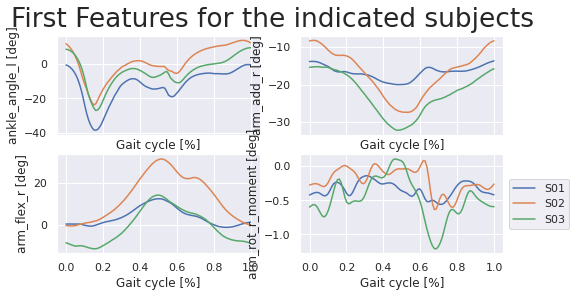

In [ ]:
gait_plot(Horst_mean, labels[0:3], index=np.r_[0,6,10,15], sd=False, title='First Features for the indicated subjects')

In [ ]:
output_label

,subject_id [number],"gender [1 = ""female"" / 0 =""male""]",age [years],body mass [kg],body size [m]
0,S01,0,29,68.90,1.75
1,S02,1,21,64.90,1.81
2,S03,0,21,80.80,1.84
3,S04,0,23,82.70,1.82
4,S05,1,26,54.90,1.63
5,S06,0,21,77.30,1.79
6,S07,0,24,94.20,1.91
7,S08,0,23,69.50,1.88
8,S09,0,26,72.00,1.84
9,S10,1,20,52.30,1.58


In [ ]:
Horst_mean_T.shape[0] == output_label.shape[0]

True

In [ ]:
from sklearn.decomposition import PCA

#transpose
Horst_mean_T = Horst_mean.loc[:,idx[:,'mean']].T
var = []
for comp in range(1,50):
  pc = PCA(n_components = comp)
  Horst_red = pc.fit_transform(Horst_mean_T)
  var.append(sum(pc.explained_variance_ratio_))


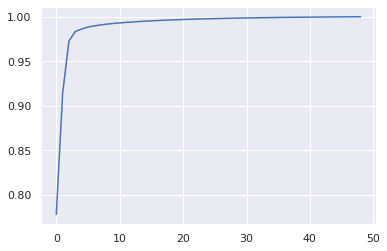

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(var)), var)
plt.show()

In [ ]:
Horst_mean_T.shape

(57, 8800)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

#Implementing Randomized search CV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 60)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#n_componenst
n_comp = range(1,25)

X_train, X_test, y_train, y_test = train_test_split(Horst_mean_T, 
                                                    output_label.loc[:,'body mass [kg]'], 
                                                    test_size=.2, \
                                                    random_state=42)

# Creating the random grid
random_grid = {'regressor__n_estimators': n_estimators,
'regressor__max_features': max_features,
'regressor__max_depth': max_depth,
'regressor__min_samples_split': min_samples_split,
'regressor__min_samples_leaf': min_samples_leaf,
'regressor__bootstrap': bootstrap,
'reducer__n_components': n_comp}

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('reducer', PCA()),
                     ('regressor', RandomForestRegressor(random_state = 42))])

rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=random_grid,
                                n_iter = 15, scoring='neg_mean_squared_error',
                                cv = 3, verbose=1, random_state=42, n_jobs=-1,
                                return_train_score=True)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   47.8s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('reducer',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('regressor',
                                              RandomForestRegressor(bootstrap=True,
        

## How to use the PCA to classify according to the data

We are going to base on the work done by **Eskofier et al** [3] which abstract is:


> *The classification of gait patterns has great potential as a diagnostic tool, for example, for the diagnosis of injury or to identify at-risk gait in the elderly. The purpose of the paper is to present a method for classifying group differences in gait pattern by using the complete spatial and temporal information of the segment motion quantified by the markers. The classification rates that are obtained are compared with previous studies using conventional classification features. For our analysis, 37 three-dimensional marker trajectories were collected from each of our 24 young and 24 elderly female subjects while they were walking on a treadmill. Principal component analysis was carried out on these trajectories to retain the spatial and temporal information in the markers. Using a Support Vector Machine with a linear kernel, a classification rate of 95.8% was obtained. This classification approach also allowed visualisation of the contribution of individual markers to group differentiation in position and time. The approach made no specific assumptions and did not require prior knowledge of specific time points in the gait cycle. It is therefore directly applicable for group classification tasks in any study involving marker measurements.*



### How the population was set up in the experiment

![population](https://drive.google.com/uc?id=1tPM95BR0RKJXewVQr_FArLogsJabCawz)

### Which were the variables implied in the human gait analysis

![markers](https://drive.google.com/uc?id=1V6qAzovgWS_Hlu8_66dfqGSU_-nuWh9C)

![marker vi](https://drive.google.com/uc?id=1fySK5muO4eubvpkxFPKQEseR-6GNwvxW)

### Which classification algorithm was applied to the problem

![marker viz](https://drive.google.com/uc?id=1Tc0JxEmy-_JFW_0K2SqbwLiEKyCNN52E)

# Your Task


1.   Be familiar with the Anthropometric concepts implied in the dataset.
2.   Rearrange the data so that you can implement a feature extraction process.
Implement a feasible and believable feature extraction process using PCA or kPCA.
3. Perform a multiclass classification process  using your prefered method. 
Determine the number of Principal Components in which you get the highest accuracy.
4. Get your own conclusions



**Plus:** Use the feature importance process to know the most important variables in the process.





[1] G. Bovi, M. Rabuffetti, P. Mazzoleni, M. Ferrarin, A multiple-task gait analysis approach: Kinematic, kinetic and EMG reference data for healthy young and adult subjects, Gait Posture. 33 (2011) 6–13. https://doi.org/10.1016/j.gaitpost.2010.08.009.

[2] J. Figueiredo, C.P. Santos, J.C. Moreno, Automatic recognition of gait patterns in human motor disorders using machine learning: A review, Med. Eng. Phys. 53 (2018) 1–12. https://doi.org/10.1016/j.medengphy.2017.12.006.

[3] B.M. Eskofier, P. Federolf, P.F. Kugler, B.M. Nigg, Marker-based classification of young-elderly gait pattern differences via direct PCA feature extraction and SVMs, Comput. Methods Biomech. Biomed. Engin. 16 (2013) 435–442. https://doi.org/10.1080/10255842.2011.624515.

[4] M.W. Whittle, Gait Analysis an Introduction, 4th ed., Elsevier, 2007.
